# Disclaimer

This notebook has been created to show you how you can train a U-Net with the free resources from Google colab. We used big chunks of code from [this kaggle notebook](https://www.kaggle.com/bonhart/brain-mri-data-visualization-unet-fpn), and of course, our [challenge dataset](https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation). 
Feel free to make changes and use the snippets for the challenge!

**Important**: Before launching the first cell, select **Runtime -> Change runtime type -> GPU**. This will greatly shorten training time. 

In [ ]:
# Connect to google drive
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


Below, we import all important libraries. To make use of the FloyBrain class, you might have to adapt the path given in `sys.path.append()` to direct python to FloyBrain.py file. 

In [ ]:
import sys
import os
import time
import numpy as np
import pandas as pd
import tqdm

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensor

# import our own code, FloyBrain
sys.path.append('/gdrive/MyDrive/CUAI')
import FloyBrain

In [ ]:
'''Downsampling of the data speeds up training time. It might also limit 
peak performance - so feel free to experiment!'''

PATCH_SIZE = 128#256

transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    A.Normalize(p=1.0),
    ToTensor(),
])

In [ ]:
'''Initialize the datasets. You will have to adapt the data_path referring 
to the kaggle_3m folder, to adjust to your file system.'''

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

dataset_train = FloyBrain.FloyBrainMriDataset(data_path = '/gdrive/MyDrive/CUAI/kaggle_3m', 
                                    split='train', transforms=transforms, available_annotations=1.0)

dataset_val = FloyBrain.FloyBrainMriDataset(split='val', transforms=transforms)

dataset_test = FloyBrain.FloyBrainMriDataset(split='test', transforms=transforms)

'''make all annotations available for training and validation set, 
for the sake of benchmarking'''
for el in range(len(dataset_train)):
  dataset_train.annotate_sample(el)
for el in range(len(dataset_val)):
  dataset_val.annotate_sample(el)

train_dataloader = DataLoader(dataset_train, batch_size=32, num_workers=4, shuffle=True)
val_dataloader = DataLoader(dataset_val, batch_size=32, num_workers=4, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=32, num_workers=4, shuffle=True)

Successfully initialized FloydDataManager. 3151 annotations can be retrieved.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  """Entry point for launching an IPython kernel.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


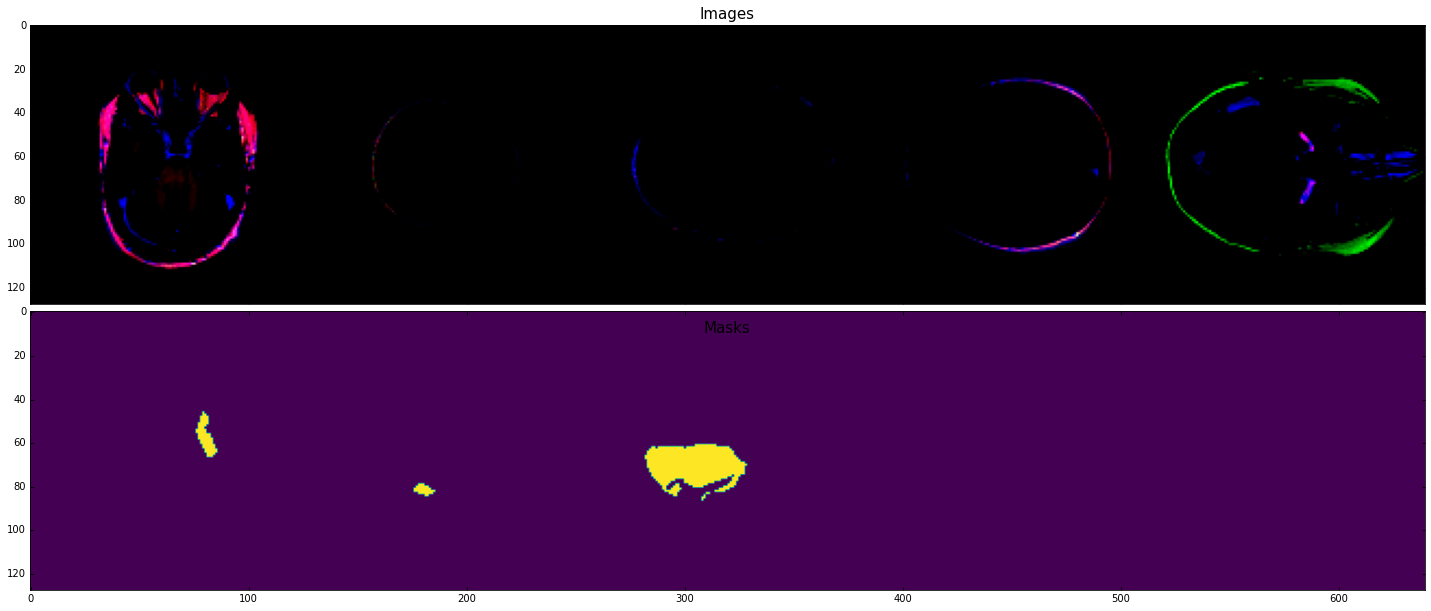

In [ ]:
from mpl_toolkits.axes_grid import ImageGrid
# Data
im_ids = [1,2,3,4,5]
sample_imgs = []
for i in im_ids:
    #print(data)
    img, mask = dataset_train[i]
    img = np.moveaxis(np.array(img), 0, -1)
    mask = np.moveaxis(np.array(mask), 0, -1)
    sample_imgs.extend([img, mask])


sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

# Plot
fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 1),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )


grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images", fontsize=15)
grid[0].axis("off")
grid[1].imshow(sample_masks_arr[..., 0])
grid[1].set_title("Masks", fontsize=15, y=0.9)
grid[1].axis("off")
plt.show()

In [ ]:
# Construct a plain U-Net

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True))
    
class UNet(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
                
    self.conv_down1 = double_conv(3, 64)
    self.conv_down2 = double_conv(64, 128)
    self.conv_down3 = double_conv(128, 256)
    self.conv_down4 = double_conv(256, 512)        

    self.maxpool = nn.MaxPool2d(2)
    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
    self.conv_up3 = double_conv(256 + 512, 256)
    self.conv_up2 = double_conv(128 + 256, 128)
    self.conv_up1 = double_conv(128 + 64, 64)
        
    self.last_conv = nn.Conv2d(64, n_classes, kernel_size=1)
        
        
  def forward(self, x):
    # Batch - 1d tensor.  N_channels - 1d tensor, IMG_SIZE - 2d tensor.
    # Example: x.shape >>> (10, 3, 256, 256).
        
    conv1 = self.conv_down1(x)  # <- BATCH, 3, IMG_SIZE  -> BATCH, 64, IMG_SIZE..
    x = self.maxpool(conv1)     # <- BATCH, 64, IMG_SIZE -> BATCH, 64, IMG_SIZE 2x down.
    conv2 = self.conv_down2(x)  # <- BATCH, 64, IMG_SIZE -> BATCH,128, IMG_SIZE.
    x = self.maxpool(conv2)     # <- BATCH, 128, IMG_SIZE -> BATCH, 128, IMG_SIZE 2x down.
    conv3 = self.conv_down3(x)  # <- BATCH, 128, IMG_SIZE -> BATCH, 256, IMG_SIZE.
    x = self.maxpool(conv3)     # <- BATCH, 256, IMG_SIZE -> BATCH, 256, IMG_SIZE 2x down.
    x = self.conv_down4(x)      # <- BATCH, 256, IMG_SIZE -> BATCH, 512, IMG_SIZE.
    x = self.upsample(x)        # <- BATCH, 512, IMG_SIZE -> BATCH, 512, IMG_SIZE 2x up.
        
    #(Below the same)                                 N this       ==        N this.  Because the first N is upsampled.
    x = torch.cat([x, conv3], dim=1) # <- BATCH, 512, IMG_SIZE & BATCH, 256, IMG_SIZE--> BATCH, 768, IMG_SIZE.
        
    x = self.conv_up3(x) #  <- BATCH, 768, IMG_SIZE --> BATCH, 256, IMG_SIZE. 
    x = self.upsample(x)  #  <- BATCH, 256, IMG_SIZE -> BATCH,  256, IMG_SIZE 2x up.   
    x = torch.cat([x, conv2], dim=1) # <- BATCH, 256,IMG_SIZE & BATCH, 128, IMG_SIZE --> BATCH, 384, IMG_SIZE.  

    x = self.conv_up2(x) # <- BATCH, 384, IMG_SIZE --> BATCH, 128 IMG_SIZE. 
    x = self.upsample(x)   # <- BATCH, 128, IMG_SIZE --> BATCH, 128, IMG_SIZE 2x up.     
    x = torch.cat([x, conv1], dim=1) # <- BATCH, 128, IMG_SIZE & BATCH, 64, IMG_SIZE --> BATCH, 192, IMG_SIZE.  
        
    x = self.conv_up1(x) # <- BATCH, 128, IMG_SIZE --> BATCH, 64, IMG_SIZE.
        
    out = self.last_conv(x) # <- BATCH, 64, IMG_SIZE --> BATCH, n_classes, IMG_SIZE.
    out = torch.sigmoid(out)
        
    return out

unet = UNet(n_classes=1).to(device)
output = unet(torch.randn(1,3,256,256).to(device))
print("",output.shape)

 torch.Size([1, 1, 256, 256])


In [ ]:
# Define metrics and Loss

def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0

    return intersection / union

# Metric check
dice_coef_metric(np.array([0., 0.9]), 
                 np.array([0., 1]))

def dice_coef_loss(inputs, target):
    smooth = 1.0
    intersection = 2.0 * ((target * inputs).sum()) + smooth
    union = target.sum() + inputs.sum() + smooth

    return 1 - (intersection / union)


def bce_dice_loss(inputs, target):
    dicescore = dice_coef_loss(inputs, target)
    bcescore = nn.BCELoss()
    bceloss = bcescore(inputs, target)

    return bceloss + dicescore

# loss check
bce_dice_loss(torch.tensor([0.7, 1., 1.]), 
              torch.tensor([1.,1.,1.]))

tensor(0.1637)

In [ ]:
# Define a training function

def train_model(model_name, model, train_loader, val_loader, train_loss, optimizer, lr_scheduler, num_epochs):  
    
    print(model_name)
    loss_history = []
    train_history = []
    val_history = []

    for epoch in range(num_epochs):
        model.train() # Enter train mode
        
        losses = []
        train_iou = []
        
        
        for i_step, (data, target) in enumerate(tqdm.tqdm(train_loader)):
            data = data.to(device)
            target = target.to(device)
                      
            outputs = model(data)
            
            out_cut = np.copy(outputs.data.cpu().numpy())
            # out_cut[np.nonzero(out_cut < 0.5)] = 0.0
            # out_cut[np.nonzero(out_cut >= 0.5)] = 1.0
            
            train_dice = dice_coef_metric(out_cut, target.data.cpu().numpy())
            
            loss = train_loss(outputs, target)
            
            losses.append(loss.item())
            train_iou.append(train_dice)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
            if lr_scheduler:
                lr_scheduler.step()
 
        #torch.save(model.state_dict(), f'{model_name}_{str(epoch)}_epoch.pt')
        val_mean_iou = compute_iou(model, val_loader)
        
        loss_history.append(np.array(losses).mean())
        train_history.append(np.array(train_iou).mean())
        val_history.append(val_mean_iou)
        
        print("Epoch [%d]" % (epoch))
        print("Mean loss on train:", np.array(losses).mean(), 
              "\nMean DICE on train:", np.array(train_iou).mean(), 
              "\nMean DICE on validation:", val_mean_iou)
        
    return loss_history, train_history, val_history


def compute_iou(model, loader, threshold=0.3):
    """
    Computes accuracy on the dataset wrapped in a loader
    
    Returns: accuracy as a float value between 0 and 1
    """
    model.eval()
    valloss = 0
    
    with torch.no_grad():

        for i_step, (data, target) in enumerate(loader):
            
            data = data.to(device)
            target = target.to(device)
            #prediction = model(x_gpu)
            
            outputs = model(data)
           # print("val_output:", outputs.shape)

            out_cut = np.copy(outputs.data.cpu().numpy())
            out_cut[np.nonzero(out_cut < threshold)] = 0.0
            out_cut[np.nonzero(out_cut >= threshold)] = 1.0

            picloss = dice_coef_metric(out_cut, target.data.cpu().numpy())
            valloss += picloss

        #print("Threshold:  " + str(threshold) + "  Validation DICE score:", valloss / i_step)

    return valloss / i_step


unet_optimizer = torch.optim.Adamax(unet.parameters(), lr=1e-3)

# Train your model.
If you have selected a GPU in the runtime settings, training for the first epoch
should take approx. 8 minutes, greatly speeding up for the consecutive epochs.

In [ ]:
# Launch training
unet_lh, unet_th, unet_vh = train_model("Vanilla_UNet", unet, train_dataloader, val_dataloader, bce_dice_loss, unet_optimizer, False, 20) 

Vanilla_UNet


  0%|          | 0/79 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 79/79 [01:20<00:00,  1.02s/it]


Epoch [0]
Mean loss on train: 2.899929208091543 
Mean DICE on train: 0.3725559338467668 
Mean DICE on validation: 0.569855223675888


100%|██████████| 79/79 [01:20<00:00,  1.02s/it]


Epoch [1]
Mean loss on train: 0.5367464345844486 
Mean DICE on train: 0.5100194753061367 
Mean DICE on validation: 0.5721202061626915


100%|██████████| 79/79 [01:20<00:00,  1.02s/it]


Epoch [2]
Mean loss on train: 0.5202353694770909 
Mean DICE on train: 0.5285096242826807 
Mean DICE on validation: 0.605245230287943


100%|██████████| 79/79 [01:20<00:00,  1.02s/it]


Epoch [3]
Mean loss on train: 0.49535829734198655 
Mean DICE on train: 0.5524350633593089 
Mean DICE on validation: 0.6186524410829941


100%|██████████| 79/79 [01:20<00:00,  1.02s/it]


Epoch [4]
Mean loss on train: 0.48484485568125035 
Mean DICE on train: 0.5588303903774149 
Mean DICE on validation: 0.6780462243451068


100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch [5]
Mean loss on train: 0.41121062900446637 
Mean DICE on train: 0.6256222499424069 
Mean DICE on validation: 0.6565991751479181


100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch [6]
Mean loss on train: 0.3660919228686562 
Mean DICE on train: 0.6665277088128427 
Mean DICE on validation: 0.7622061100073209


100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch [7]
Mean loss on train: 0.37438394299036337 
Mean DICE on train: 0.6583957313801906 
Mean DICE on validation: 0.7566501114182009


100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch [8]
Mean loss on train: 0.3886311957730523 
Mean DICE on train: 0.6474898860480364 
Mean DICE on validation: 0.5549487214256832


100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch [9]
Mean loss on train: 0.3657054091933407 
Mean DICE on train: 0.6660373039622857 
Mean DICE on validation: 0.773874614874636


100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch [10]
Mean loss on train: 0.3220468644477144 
Mean DICE on train: 0.705920108432091 
Mean DICE on validation: 0.7904448219044473


100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch [11]
Mean loss on train: 0.31492307291755195 
Mean DICE on train: 0.7131217423061714 
Mean DICE on validation: 0.772457938329979


100%|██████████| 79/79 [01:21<00:00,  1.04s/it]


Epoch [12]
Mean loss on train: 0.3171991268290749 
Mean DICE on train: 0.7105208927858472 
Mean DICE on validation: 0.7902215920141789


100%|██████████| 79/79 [01:21<00:00,  1.04s/it]


Epoch [13]
Mean loss on train: 0.3004924692685091 
Mean DICE on train: 0.7275758035685723 
Mean DICE on validation: 0.7967815338332621


100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch [14]
Mean loss on train: 0.31207450092593325 
Mean DICE on train: 0.7165868656269673 
Mean DICE on validation: 0.7571107668149006


100%|██████████| 79/79 [01:21<00:00,  1.04s/it]


Epoch [15]
Mean loss on train: 0.29674098970769325 
Mean DICE on train: 0.7295002452541984 
Mean DICE on validation: 0.7876926284645439


100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch [16]
Mean loss on train: 0.2990679837103131 
Mean DICE on train: 0.726729957671367 
Mean DICE on validation: 0.8011468594233918


100%|██████████| 79/79 [01:21<00:00,  1.04s/it]


Epoch [17]
Mean loss on train: 0.2988267799344244 
Mean DICE on train: 0.7290215969744125 
Mean DICE on validation: 0.817674749139886


100%|██████████| 79/79 [01:21<00:00,  1.03s/it]


Epoch [18]
Mean loss on train: 0.2777875765592237 
Mean DICE on train: 0.7459148760015457 
Mean DICE on validation: 0.8278148825196129


100%|██████████| 79/79 [01:21<00:00,  1.04s/it]


Epoch [19]
Mean loss on train: 0.2865383227037478 
Mean DICE on train: 0.7367431959411853 
Mean DICE on validation: 0.8183605082242417
